## Dataset

The dataset contains 18 csv files. These are the different sets of data collected from project 2. They were all stored in csv files for the sake of replication and keeping the datasets consistent. For each of the 9 dataset variants, there is an "action" file and a "state" file.

1. Expert (in 100, 250, and 500 episode variants) (state action)
2. Expert_Random (in 100, 250, and 500 episode variants) (state action)
3. Random (in 100, 250, and 500 episode variants) (state action)

So each csv is for one type of data with a certain number of episodes and is either the action (Y data in a logistic Regression) or the state (X data in a logistic regression).

In each CSV the left most coloumn is to be ignored it is just the row index. In the action CSV the remaining column is the action: 0 or 1. The state CSV contains the 4 remaining state values in the other columns as given by gymansium in env.step().

The data for this project will be submitted as seperate files with this IPYNB file and everything in one Zip file.

Google import (personal use only)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/579_assignment_4_data/assignment_4_data/*.* .
!ls

Mounted at /content/drive
579a3q2-shared.ipynb	      action_Random_100.csv  Expert_random_100.csv
action_Expert_100.csv	      action_Random_250.csv  Expert_random_250.csv
action_Expert_250.csv	      action_Random_500.csv  Expert_random_500.csv
action_Expert_500.csv	      drive		     Random_100.csv
action_Expert_random_100.csv  Expert_100.csv	     Random_250.csv
action_Expert_random_250.csv  Expert_250.csv	     Random_500.csv
action_Expert_random_500.csv  Expert_500.csv	     sample_data


#Imports

The imported library is Gymnasium. This is not by default in Python therefore it must be pip installed.

In [ ]:
!pip install gymnasium[classic-control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


There are only 3 imports for this HW.

Numpy, Gymnasium and sklearn LR.

Numpy of course is for dataprocessing. Gymnasium is for the environment and sklearn LR is for immitation learning.

In [ ]:
import numpy as np
import gymnasium as gym
print(gym.__version__)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

0.28.1


#Main Code

General Scripts (used throughout the project)

In [ ]:
# given an observation, discretize it
def get_bin_index(observation, bins, min, max):
  if (observation < min):
    return 0
  if (observation > max):
    return bins-1
  return int((observation-min)/((max-min)/bins))

In [ ]:
# Read the state and action CSV files. 
# Outputs three lists: states, actions, and rewards
# These correspond to the state, action, reward for each timestep
def read_from_past(state_file, action_file):
  states = np.genfromtxt(state_file, skip_header=1, usecols=(1,2,3,4), delimiter=',')
  actions = np.genfromtxt(action_file, dtype=np.int32, skip_header=1, usecols=(1), delimiter=',')
  last_angle = 0
  last_pos = 0
  rewards = []
  timestep_count = 0
  for i in range(1, len(states)):
    # recognize episode boundaries by detecting large changes in angle, position
    # or a timestep of 500
    if abs(states[i][2]-last_angle) > 0.1 or abs(states[i][0]-last_pos > 2) or timestep_count == 500:
      rewards.append(0)
      timestep_count = 0
      # print("appending")
    else:
      rewards.append(1)
      timestep_count += 1
    last_angle = states[i][2]
    last_pos = states[i][0]
  rewards.append(0)
  return states, actions, rewards

states, actions, rewards = read_from_past('Expert_100.csv', 'action_Expert_100.csv')
count_zero = 0
for reward in rewards:
  count_zero += int(reward==0)
count_zero

100

# Fitted-Q Learning

In [ ]:
class Fitted_Q:
  def __init__(self, alpha, gamma, states, actions, rewards, K):
    self.weights = np.random.uniform(-0.001,0.001,(1,81))
    self.alpha=alpha
    self.gamma=gamma
    self.states=states
    self.actions = actions
    self.rewards=rewards
    self.state_action_features = np.array([self.to_features(states[i], actions[i]) for i in range(len(states))])
    self.K = K


  def set_target(self):
    # compute y_i
    temp = [1 + self.gamma * (0 if self.rewards[i] == 0 else self.get_max_q(self.states[i]).item()) for i in range(len(self.rewards))]
    
    self.y = np.array(temp).reshape(-1, 1)
  
  # update weights (phi)
  def batch_gradient_descent(self):
    num_epoch = 5
    m = self.state_action_features.shape[0]
    # print("m", m)
    # print("state_action_features", self.state_action_features.shape)
    # print("weights", self.weights.shape)
    for epoch in range(num_epoch):
      hypothesis = np.dot(self.state_action_features, self.weights.T)
      # print("hypothesis", hypothesis.shape)
      diff = hypothesis - self.y
      # print("diff", diff.shape)
    #   cost = np.sum(diff ** 2) / (2 * m)
      gradient = np.dot(self.state_action_features.T, diff) / m
      # print("gradient", gradient.shape)
      self.weights = self.weights - self.alpha * gradient.T
      # print("new weights", self.weights.shape)
  # bin all the features into 10 bins using the ranges below
  def to_features(self, observation, action):
    features = np.zeros(81)
    features[80] = 1 # bias term
    action_padding = 0 if action == 0 else 40
    # print(observation)
    features[get_bin_index(observation[0], 10, -2.4, 2.4)+action_padding] = 1
    features[get_bin_index(observation[1], 10, -3,3)+10+action_padding] = 1
    features[get_bin_index(observation[2], 10, -0.3, 0.3)+20+action_padding] = 1
    features[get_bin_index(observation[3], 10, -3, 3)+30+action_padding] = 1


    return features
  def get_max_q(self, state):
    # print(np.dot(self.weights, self.to_features(state, 0)), np.dot(self.weights, self.to_features(state, 1)))
    return max(np.dot(self.weights, self.to_features(state, 0)), np.dot(self.weights, self.to_features(state, 1)))
  def provide_action(self, state):
    left_q = np.dot(self.weights, self.to_features(state, 0))
    right_q = np.dot(self.weights, self.to_features(state, 1))
    action = 0 if left_q > right_q else 1
    # print(action)
    return action
  def train(self):
    # print(self.weights)
    for i in range(self.K):
      self.set_target()
      self.batch_gradient_descent()

In [ ]:
# returns mean, std for the 100 episodes
def run_fitted_q(alpha, gamma, K, dataset):
    print("Running Fitted Q on dataset {}".format(dataset))
    states, actions, rewards = read_from_past('{}.csv'.format(dataset), 'action_{}.csv'.format(dataset))
    agent = Fitted_Q(alpha, gamma, states, actions, rewards, K)
    agent.train()
    env = gym.make("CartPole-v1")
    observation, info = env.reset()
    episode_number = 0
    timestep = 0
    return_per_episode = []
    while (episode_number < 100):
        action = agent.provide_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        # agent.update_weights(reward, observation, next_observation, action, terminated)
        observation = next_observation
        if terminated or truncated:
            return_per_episode.append(timestep)
            # print("Testing: Episode terminated after {} timesteps".format(timestep))
            timestep = 0
            episode_number += 1
            observation, info = env.reset()
            continue
            
        timestep += 1
    env.close()
    return np.mean(return_per_episode), np.std(return_per_episode)

#Immitation Learning

In [60]:


def immitation_learning(dataset,parameter_C):
    states, actions, rewards = read_from_past('{}.csv'.format(dataset), 'action_{}.csv'.format(dataset))
    output = []
    mean = 0
    std = 0
    clf = LogisticRegression(random_state=0,C = parameter_C).fit(states, actions)
    print("Logistic Regression Accuracy Score: ",clf.score(states,actions))
    seeds = range(50,60)
    for i in range(100):
      action_list = []
      length = 0
      terminated = False
      truncated = False
      env = gym.make("CartPole-v1")#,render_mode='human')
      observation, info = env.reset()#seed=seeds[i%25])
      while not terminated:

        action = clf.predict([observation])
        action_list.append(action[0])
        #print(action)
        #print("end: ", terminated)
        observation, reward, terminated, truncated, info = env.step(action[0])

        length += 1
      env.close()

      #print(length)
      output.append(length)
      #print(action_list)
    output = np.array(output)
    mean = np.mean(output)
    std = np.std(output)
    return mean, std


    

Running All the Codes

In [66]:
result_Q_1 = {}
result_Q_2 = {}
result_LR_1 = {}
result_LR_2 = {}
for mode in ['Expert', 'Expert_random', 'Random']:
  for dataset_size in [100,250,500]:
    dataset = '{}_{}'.format(mode, dataset_size)
    #print("data: ",dataset)
    result_LR_1[dataset] = immitation_learning(dataset,1)
    result_LR_2[dataset] = immitation_learning(dataset,3)
    result_Q_1[dataset] = run_fitted_q(0.0625, 1, 5, dataset)
    result_Q_2[dataset] = run_fitted_q(1/4, 1, 5, dataset)



Logistic Regression Accuracy Score:  0.9572783309625414
Logistic Regression Accuracy Score:  0.957325746799431
Running Fitted Q on dataset Expert_100
Running Fitted Q on dataset Expert_100
Logistic Regression Accuracy Score:  0.9561688940538446
Logistic Regression Accuracy Score:  0.9558396281231842
Running Fitted Q on dataset Expert_250
Running Fitted Q on dataset Expert_250
Logistic Regression Accuracy Score:  0.9611609632942235
Logistic Regression Accuracy Score:  0.9608967521601707
Running Fitted Q on dataset Expert_500
Running Fitted Q on dataset Expert_500
Logistic Regression Accuracy Score:  0.9611527601986175
Logistic Regression Accuracy Score:  0.9605685911790478
Running Fitted Q on dataset Expert_random_100
Running Fitted Q on dataset Expert_random_100
Logistic Regression Accuracy Score:  0.9583057061507859
Logistic Regression Accuracy Score:  0.9586177308007332
Running Fitted Q on dataset Expert_random_250
Running Fitted Q on dataset Expert_random_250
Logistic Regression Acc

Results

In [67]:
print(result_Q_1)
print(result_Q_2)

{'Expert_100': (203.34, 43.2687462263468), 'Expert_250': (197.46, 42.20483858516698), 'Expert_500': (194.23, 41.747300511530085), 'Expert_random_100': (203.67, 41.78709250474362), 'Expert_random_250': (196.85, 38.86524797296423), 'Expert_random_500': (199.35, 42.0738339113516), 'Random_100': (10.62, 1.405560386465128), 'Random_250': (16.16, 19.37664573655616), 'Random_500': (10.28, 2.676116589388437)}
{'Expert_100': (201.46, 38.473476578027096), 'Expert_250': (196.39, 40.65855260581714), 'Expert_500': (195.52, 40.12068793029352), 'Expert_random_100': (194.89, 38.789404481120876), 'Expert_random_250': (200.75, 37.907090365787774), 'Expert_random_500': (196.67, 37.85315178423059), 'Random_100': (8.85, 2.3254031908466968), 'Random_250': (17.31, 28.92427872912305), 'Random_500': (9.03, 2.2425654951416694)}


In [68]:
print(result_LR_1)
print(result_LR_2)

{'Expert_100': (212.92, 58.90868866304868), 'Expert_250': (231.65, 70.68781719645897), 'Expert_500': (237.03, 71.68088378361415), 'Expert_random_100': (200.54, 49.47795872911493), 'Expert_random_250': (217.94, 61.97238417230694), 'Expert_random_500': (221.05, 54.79057856967748), 'Random_100': (9.59, 0.6941901756723442), 'Random_250': (42.51, 11.882335628991466), 'Random_500': (9.9, 0.5744562646538027)}
{'Expert_100': (220.51, 71.65409897556455), 'Expert_250': (251.32, 92.99149208395357), 'Expert_500': (254.54, 84.71356680012947), 'Expert_random_100': (223.21, 69.24309279632156), 'Expert_random_250': (246.94, 86.22259796596249), 'Expert_random_500': (256.16, 102.7266002552406), 'Random_100': (9.6, 0.648074069840786), 'Random_250': (38.27, 10.88012408017482), 'Random_500': (9.86, 0.5102940328869229)}


# Bonus

In [69]:

class Mlp_agent:
  def __init__(self, states, actions):
    self.classifier = clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    self.states=states
    self.actions = actions

  def provide_action(self, state):
    action = self.classifier.predict(np.array(state).reshape(1,-1))[0]
    # print(action)
    return action
  def train(self):
    self.classifier.fit(np.array(self.states), np.array(self.actions))

# It is not clear from the assignment whether we need to incorporate MLP on Fitted-q-learning. The code as below works. It performs poorly compared
# to the Mlp_agent. It achieves a mean return of 58 on expert_100. 

# class Mlp_q_value_agent:
#   def __init__(self, states, actions, rewards):
#     self.classifier = clf = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=(100, 100), random_state=1, early_stopping=True)
#     self.states=states
#     self.actions = actions
#     self.rewards = rewards
#     self.state_action_features = np.array([self.to_features(states[i], actions[i]) for i in range(len(states))])
#     self.state_action_q = [] # each element corresponds to the return of the state_action at that timestep
#     state_action_return = 0
#     for reward in rewards[::-1]:
#       if reward == 0:
#         state_action_return = 0
#       else:
#         state_action_return += 1
#       self.state_action_q.insert(0, state_action_return)
#     print(self.state_action_q)
#   def to_features(self, observation, action):
#     features = np.zeros(81)
#     features[80] = 1 # bias term
#     action_padding = 0 if action == 0 else 40
#     # print(observation)
#     features[get_bin_index(observation[0], 10, -2.4, 2.4)+action_padding] = 1
#     features[get_bin_index(observation[1], 10, -3,3)+10+action_padding] = 1
#     features[get_bin_index(observation[2], 10, -0.3, 0.3)+20+action_padding] = 1
#     features[get_bin_index(observation[3], 10, -3, 3)+30+action_padding] = 1


#     return features

#   def provide_action(self, state):
#     state_action_left = np.array(self.to_features(state, 0)).reshape(1,-1)
#     state_action_right = np.array(self.to_features(state, 1)).reshape(1,-1)
#     q_left = self.classifier.predict(state_action_left)[0]
#     q_right = self.classifier.predict(state_action_right)[0]
#     print(q_left, q_right)
#     return 0 if q_left > q_right else 1
#   def train(self):
#     self.classifier.fit(self.state_action_features, np.array(self.state_action_q))

In [70]:
# returns mean, std for the 100 episodes
def run_mlp(dataset):
    print("Running MLP on dataset {}".format(dataset))
    states, actions, rewards = read_from_past('{}.csv'.format(dataset), 'action_{}.csv'.format(dataset))
    agent = Mlp_agent(states, actions)
    # agent = Mlp_q_value_agent(states, actions, rewards)
    agent.train()
    env = gym.make("CartPole-v1")
    observation, info = env.reset()
    episode_number = 0
    timestep = 0
    return_per_episode = []
    while (episode_number < 100):
        action = agent.provide_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        # agent.update_weights(reward, observation, next_observation, action, terminated)
        observation = next_observation
        if terminated or truncated:
            return_per_episode.append(timestep)
            # print("Testing: Episode terminated after {} timesteps".format(timestep))
            timestep = 0
            episode_number += 1
            observation, info = env.reset()
            continue
            
        timestep += 1
    env.close()
    return np.mean(return_per_episode), np.std(return_per_episode)
mlp_result = {}
for mode in ['Expert', 'Expert_random', 'Random']:
  for dataset_size in [100,250,500]:
    dataset = '{}_{}'.format(mode, dataset_size)
    mlp_result[dataset] = run_mlp(dataset)
print(mlp_result)

Running MLP on dataset Expert_100
Running MLP on dataset Expert_250
Running MLP on dataset Expert_500
Running MLP on dataset Expert_random_100
Running MLP on dataset Expert_random_250
Running MLP on dataset Expert_random_500
Running MLP on dataset Random_100
Running MLP on dataset Random_250
Running MLP on dataset Random_500
{'Expert_100': (203.83, 42.78038218623111), 'Expert_250': (190.24, 41.532425886287925), 'Expert_500': (198.27, 40.832059708028446), 'Expert_random_100': (192.4, 39.06456194557927), 'Expert_random_250': (193.22, 41.254958489859135), 'Expert_random_500': (198.59, 39.04538256951774), 'Random_100': (9.74, 1.136837719289785), 'Random_250': (8.83, 1.0300970828033638), 'Random_500': (8.27, 0.759670981412348)}


#Plots

### Note about the charts
*The assignment did not specify how to present result with the two different learning rates. ALthough the report did only ask for charts with 6 bars (3 LR and 3 Q-fitted), the most natural solution is add the bonus and the different learning rates to the charts. This will make the conclusion of the report more straight forward to explain (since all the data are in these plots)*

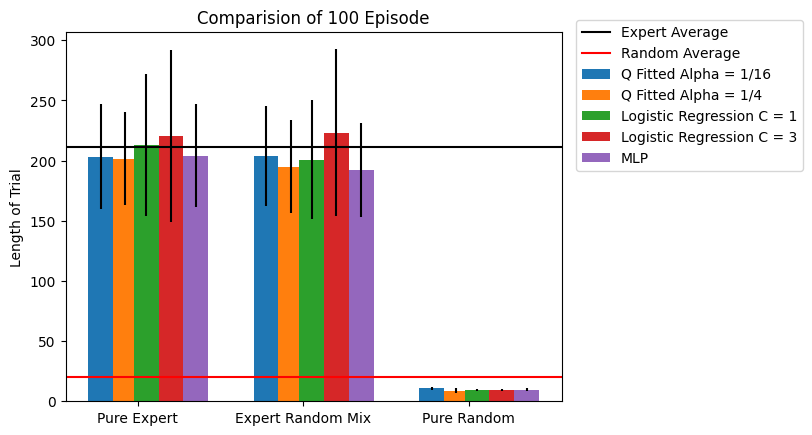

In [71]:
Q1, Q1_std = (result_Q_1['Expert_100'][0], result_Q_1['Expert_random_100'][0], result_Q_1['Random_100'][0]), (result_Q_1['Expert_100'][1], result_Q_1['Expert_random_100'][1], result_Q_1['Random_100'][1])
Q2, Q2_std = (result_Q_2['Expert_100'][0], result_Q_2['Expert_random_100'][0], result_Q_2['Random_100'][0]), (result_Q_2['Expert_100'][1], result_Q_2['Expert_random_100'][1], result_Q_2['Random_100'][1])
LR1, LR1_std = (result_LR_1['Expert_100'][0], result_LR_1['Expert_random_100'][0], result_LR_1['Random_100'][0]), (result_LR_1['Expert_100'][1], result_LR_1['Expert_random_100'][1], result_LR_1['Random_100'][1])
LR2, LR2_std = (result_LR_2['Expert_100'][0], result_LR_2['Expert_random_100'][0], result_LR_2['Random_100'][0]), (result_LR_2['Expert_100'][1], result_LR_2['Expert_random_100'][1], result_LR_2['Random_100'][1])

MLP1, MLP1_std = (mlp_result['Expert_100'][0], mlp_result['Expert_random_100'][0], mlp_result['Random_100'][0]), (mlp_result['Expert_100'][1], mlp_result['Expert_random_100'][1], mlp_result['Random_100'][1])

ind = np.arange(len(LR1))  # the x locations for the groups
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2-.15, Q1, width, yerr=Q1_std,
                label='Q Fitted Alpha = 1/16')
rects2 = ax.bar(ind + width/2-.15, Q2, width, yerr=Q2_std,
                label='Q Fitted Alpha = 1/4')
rects3 = ax.bar(ind + width*2-.1-.15, LR1, width, yerr=LR1_std,
                label='Logistic Regression C = 1')
rects4 = ax.bar(ind + width*3-.1-.15, LR2, width, yerr=LR2_std,
                label='Logistic Regression C = 3')
rects5 = ax.bar(ind + width*4-.1-.15, MLP1, width, yerr=MLP1_std,
                label='MLP')
ax.axhline(y=210.9,color='black', label = "Expert Average") # the expert policy average
ax.axhline(y=20.06,color='red', label='Random Average')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length of Trial')
ax.set_title('Comparision of 100 Episode')
ax.set_xticks(ind)
ax.set_xticklabels(('Pure Expert', 'Expert Random Mix', 'Pure Random'))
ax.legend(bbox_to_anchor=(1.5, 1.05))

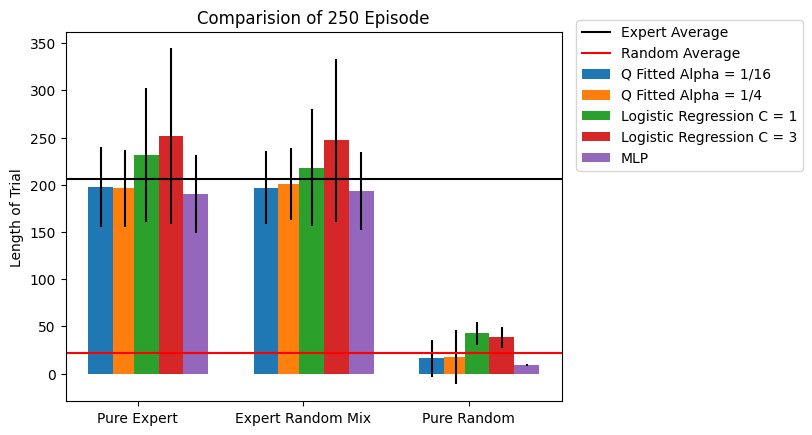

In [72]:
Q1, Q1_std = (result_Q_1['Expert_250'][0], result_Q_1['Expert_random_250'][0], result_Q_1['Random_250'][0]), (result_Q_1['Expert_250'][1], result_Q_1['Expert_random_250'][1], result_Q_1['Random_250'][1])
Q2, Q2_std = (result_Q_2['Expert_250'][0], result_Q_2['Expert_random_250'][0], result_Q_2['Random_250'][0]), (result_Q_2['Expert_250'][1], result_Q_2['Expert_random_250'][1], result_Q_2['Random_250'][1])
LR1, LR1_std = (result_LR_1['Expert_250'][0], result_LR_1['Expert_random_250'][0], result_LR_1['Random_250'][0]), (result_LR_1['Expert_250'][1], result_LR_1['Expert_random_250'][1], result_LR_1['Random_250'][1])
LR2, LR2_std = (result_LR_2['Expert_250'][0], result_LR_2['Expert_random_250'][0], result_LR_2['Random_250'][0]), (result_LR_2['Expert_250'][1], result_LR_2['Expert_random_250'][1], result_LR_2['Random_250'][1])

MLP1, MLP1_std = (mlp_result['Expert_250'][0], mlp_result['Expert_random_250'][0], mlp_result['Random_250'][0]), (mlp_result['Expert_250'][1], mlp_result['Expert_random_250'][1], mlp_result['Random_250'][1])

ind = np.arange(len(LR1))  # the x locations for the groups
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2-.15, Q1, width, yerr=Q1_std,
                label='Q Fitted Alpha = 1/16')
rects2 = ax.bar(ind + width/2-.15, Q2, width, yerr=Q2_std,
                label='Q Fitted Alpha = 1/4')
rects3 = ax.bar(ind + width*2-.1-.15, LR1, width, yerr=LR1_std,
                label='Logistic Regression C = 1')
rects4 = ax.bar(ind + width*3-.1-.15, LR2, width, yerr=LR2_std,
                label='Logistic Regression C = 3')
rects5 = ax.bar(ind + width*4-.1-.15, MLP1, width, yerr=MLP1_std,
                label='MLP')
ax.axhline(y=206.52,color='black', label = "Expert Average")
ax.axhline(y=21.35,color='red', label='Random Average')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length of Trial')
ax.set_title('Comparision of 250 Episode')
ax.set_xticks(ind)
ax.set_xticklabels(('Pure Expert', 'Expert Random Mix', 'Pure Random'))
ax.legend(bbox_to_anchor=(1.5, 1.05))

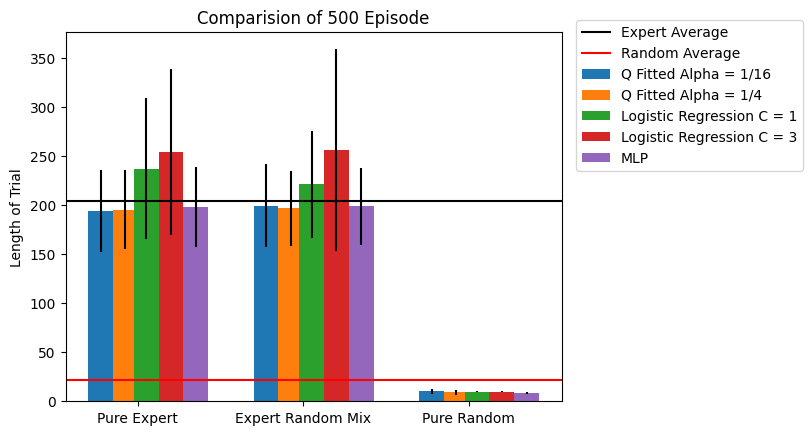

In [74]:
Q1, Q1_std = (result_Q_1['Expert_500'][0], result_Q_1['Expert_random_500'][0], result_Q_1['Random_500'][0]), (result_Q_1['Expert_500'][1], result_Q_1['Expert_random_500'][1], result_Q_1['Random_500'][1])
Q2, Q2_std = (result_Q_2['Expert_500'][0], result_Q_2['Expert_random_500'][0], result_Q_2['Random_500'][0]), (result_Q_2['Expert_500'][1], result_Q_2['Expert_random_500'][1], result_Q_2['Random_500'][1])
LR1, LR1_std = (result_LR_1['Expert_500'][0], result_LR_1['Expert_random_500'][0], result_LR_1['Random_500'][0]), (result_LR_1['Expert_500'][1], result_LR_1['Expert_random_500'][1], result_LR_1['Random_500'][1])
LR2, LR2_std = (result_LR_2['Expert_500'][0], result_LR_2['Expert_random_500'][0], result_LR_2['Random_500'][0]), (result_LR_2['Expert_500'][1], result_LR_2['Expert_random_500'][1], result_LR_2['Random_500'][1])
MLP1, MLP1_std = (mlp_result['Expert_500'][0], mlp_result['Expert_random_500'][0], mlp_result['Random_500'][0]), (mlp_result['Expert_500'][1], mlp_result['Expert_random_500'][1], mlp_result['Random_500'][1])

ind = np.arange(len(LR1))  # the x locations for the groups
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2-.15, Q1, width, yerr=Q1_std,
                label='Q Fitted Alpha = 1/16')
rects2 = ax.bar(ind + width/2-.15, Q2, width, yerr=Q2_std,
                label='Q Fitted Alpha = 1/4')
rects3 = ax.bar(ind + width*2-.1-.15, LR1, width, yerr=LR1_std,
                label='Logistic Regression C = 1')
rects4 = ax.bar(ind + width*3-.1-.15, LR2, width, yerr=LR2_std,
                label='Logistic Regression C = 3')
rects5 = ax.bar(ind + width*4-.1-.15, MLP1, width, yerr=MLP1_std,
                label='MLP')
ax.axhline(y=204.38,color='black', label = "Expert Average")
ax.axhline(y=21.67,color='red', label='Random Average')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length of Trial')
ax.set_title('Comparision of 500 Episode')
ax.set_xticks(ind)
ax.set_xticklabels(('Pure Expert', 'Expert Random Mix', 'Pure Random'))
ax.legend(bbox_to_anchor=(1.5, 1.05))

# Experiment Report
## The expert action dataset chosen for offline learning
We collected the expert actions using the agent from A2. Specifically, we used the Q-learning agent that has been trained for 1000 episodes. 

## Imitation Learning Description
Immitation Learning:

Immitation Learning is fundamentally based around Logistic Regression. The whole point as the name implies is to immitate that actions of the training dataset. This is a simple case of using sklearn's Logistic Regression library and passing the necessary datasets through it. For the sake of this experiment the datasets were: 
1. Expert (in 100, 250, and 500 episode variants)
2. Expert_Random (in 100, 250, and 500 episode variants)
3. Random (in 100, 250, and 500 episode variants)

This data is split up into two segments. The first part is the state and the second is the action. The state data in the datasets will be used in the sklearn's X value and then the y value is the actions. We are trying to immitate the actions so we try to get the best accuracy of the data's action as possible

The match accuracy of the Logistic Regression algorithm from Sklearn was over 95% (using ".score() from sklearn") in both the expert and expert/random datasets. This fell to 50% in the pure random datasets. This explains why those sets have low scores in the cartpole experiments. It is because there is no pattern for them to learn and they mearly guess the values

Since the Sklearn Logistic Regression library does not allow for changing the learning rates the hyperparameter testing was done on the C value of the LR method.

The C value in Logistic Regression refers to its regularization strength. This changes the data to effect reduce its generalization error but not in its trainning data. 


## Fitted-Q-Learning Description:
In this part of the experiment, we used the fitted-q-learning. This relies on learning the Q-values from the expert action dataset. Specifically, the Q-value is modelled as a linear function of some parameters. One difference between q-learning from A2 and fitted-q-learning in this assignment is that in this assignment, we have access to all the dataset at once. Therefore, we can treat the entire dataset as a batch. 

The algorithm for fitted-q-learning is as below:
1. collect dataset $\left\{\left(\mathbf{s}_i, \mathbf{a}_i, \mathbf{s}_i^{\prime}, r_i\right)\right\}$ using some policy

Repeat for K times (where K is a hyperparameter):

  2. set $\mathbf{y}_i \leftarrow r\left(\mathbf{s}_i, \mathbf{a}_i\right)+\gamma \max _{\mathbf{a}_i^{\prime}} Q_\phi\left(\mathbf{s}_i^{\prime}, \mathbf{a}_i^{\prime}\right)$
  3. set $\phi \leftarrow \arg \min _\phi \frac{1}{2} \sum_i\left\|Q_\phi\left(\mathbf{s}_i, \mathbf{a}_i\right)-\mathbf{y}_i\right\|^2$

We select $\gamma = 1$ because of the episodic nature of the task and because value of rewards should be be time-discounted.

$\mathbf{y}_i$ is the "target" Q-value we need to model. Step 2 sets that target based on actual rewards. Step 3 chooses parameter weights that minimizes the sumof differences between predicted Q and target Q across the entire batch. Step 3 is performed by using batch gradient descent. This means step 3 involves going through multiple epochs, where each epoch updates $\phi$ (the q-value weights) until it converges close to the minimum. 

We tested various epoch counts (1,2,3,5,10,15) and empirically determined an appropriate number of epochs for our dataset to be 5. It has a good balance between accuracy and speed. We also attemped using the absolute difference between target and predicted q-values to determine convergence. As the final result is not significantly different from using the epoch count, we used epoch counts for step 3 due to simplicity. 



We arbitrarily selected the hyperparameter K to be 5. We ran the experiment for expert_100 for different values of K in the range 3,5,...,13, for alpha = 1/16. The mean return for the different values of K differ only marginally. As a result, we did not change our initial K value. 

|  K | Mean return |
|:--:|-------------|
|  3 | 199.94      |
|  5 | 199.77      |
|  7 | 199.46      |
|  9 | 200.68      |
| 11 | 194.0       |
| 13 | 200.09      |

We experimented with two different learning rates, $\alpha = \frac{1}{4}$ and $\alpha = \frac{1}{16}$.

## Logistic Regression Conclusion:
Overall the Expert Data won against all cases of Expert data mixed with Random Data and all cases of just Random Data. This points to the fact that adding random data to expert data does not overall improve the results. A case could be made that in theory it should help against overfitting data but the results do not really back this up since at best case (which would be the case of LR 500 expert versus LR 500 expert/random) the results are nearly identical. In the other two cases the Expert trained LR wins outright. 


The interesting scenario in regards to the expert/random dataset comes in the 500 expert/random dataset versus the 250 pure expert dataset. In this case the results are actually similar. The duration of "life" for the cartpole was similar. This makes sense because the 500 expert/random dataset contains 250 episodes of pure expert data. Pure expert episodes last longer so there is more data of expert actions in them than the 250 episodes of random data. But still in this case the results for both were nearly virtual. This means than in all cases tests there were really no benefits of adding random data to expert data. More expert data is better. 

The pure random datasets caused the agent to perform terribly on cartpole, as expected. This is due to the fact you are training on random data. Logistic regression looks for patterns in what action should be done when to keep the cartpole alive and in random data there are no paterns to follow. 


The Hyperparameter testing did show that higher values in C of logistic regression did seem to increase the accuracy by a bit but not substantially. We tested in cases where C = 1 which is the default of Sklearn Logistic regression and we tried other values. The value of 3 seemed to be the best and after that any increases seemed to decrease the overall accuracy. (This can be tested by just running the LR tests for the sake of this report we were told to only show two cases.))

## Fitted-q-learning
As in LR, we observed that, given the same dataset size, the expert-random mix performs nearly as well as the expert dataset. This is because although expert and random are 50% each in terms of episode count, random episodes end much faster, so overall the percentage of expert actions are much larger than the random actions in the expert-random dataset. Even using data from 100 episodes, fitted-q-learning agent using expert data has reached close to a return of 200. 

The best alpha value is 1/4. 


## Overall Conclusion:


### Comparison between LR and Fitted-Q
Overall, Logistic Regression marginally outperforms Q fitted, especially with pure expert data. Both estimators result in high variance, but that was because of the high-variance expert agent we chose. 

The only cases where LR are on par with or performs worse than fitted-q is in cases where there are random data. This is not in all cases but some. 

In the pure random cases, half the time (across all episode counts) the LR is beaten by Q fitted. However, this is based on random data therefore the guesses from Q fitted or LR are also technically random, so this is meaningless. 

The diffence between LR and Fitted-q performance increaseses as the dataset size increases. In the case of expert_random_100 dataset, Q fitted with an alpha of 1/4 is comparable to LR. In future experiments it would be interesting to see results in cases with even smaller datasets to see if this principles holds. This could entail datasets of just 50 episodes (with a expert/random split). The issue would be if the dataset is too small there might not be enough data to train LR and Q fitted methods.

### comparison with expert policies
As expected, at 100 episodes, the agent underperforms compared to the expert policy. That is because it did not have enough data to understand the expert behavior. As the number of episode increases, the performance becomes closer to that of expert policy. In the 250 and 500 episode case, LR outperforms the expert policy. It is possible LR uses the advantage of being able to review expert actions in batches to identify a trend. 
The expert policy may have overfitted, and the trend approximation found by logistical regression may better correspond to optimal action. 


Another interesting test for future experiments would be to try other ML methods for the immitation learning. As seen in COMP.551 and ECSE.551 especially in cases with a more and more features (and eventually actions) random forest and decision trees are good and efficient methods to use. It would be interesting to see if they would beat out LR or Qfitted.

The increase in dataset size does not significantly impact Q fitted (regardless of the alpha value). Its episode duration is always roughly 200. LR does seem to benefit slightly from increased amounts of data. But it does not benefit more than 5-10 points of duration for every doubling of the dataset episdoe count. MLP does not benefit whatsoever from increased data. It stays consistent.


Changing the dataset to have partial random data does not really change much. The results across the board (across all methods and algorithms) are fairly consistent. The difference comes when the dataset becomes when the pure random data and the result become guesses meaning the duration of each episdoe falls.

### Multi-layer Perceptron
For the bonus, we used the multi-layer perceptron from SK learn to learn actions when given a state. It's a 4-layer MLP, with 2 hidden layers with 5 and 2 perceptrons each. It achieved a mean return of around 200. It uses the 'lbfgs' optimizer and 'relu' activation. 

It is not clear from the assignment whether we need to incorporate MLP on Fitted-q-learning. In this second approach, the idea is to learn the q-values instead of the actions, and use the MLP to find a q-value for both actions given a state, before picking the one with the higher q-value. 

We successfully implemented MLP on fitted-q-learning. It performs relatively poorly compared to the Mlp_agent. It achieves a mean return of 58 on expert_100 dataset. We have commented out this second approach out of our code. 